## [Import data]

In [1]:
!pip install pandas==2.2.1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2


In [3]:
TRAIN_INPUT = "data/x_train.csv"
TRAIN_OUTPUT = "data/y_train.csv"
TEST_INPUT = "data/x_test.csv"

In [4]:
x_train = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)

In [5]:
#datetime data
x_train.set_index(pd.to_datetime(x_train.index, utc=True), inplace=True)
y_train.set_index(pd.to_datetime(y_train.index, utc=True), inplace=True)
x_test.set_index(pd.to_datetime(x_test.index, utc=True), inplace=True)

In [6]:
print(f"Training data : from {x_train.index.min()} to {x_train.index.max()}")
print(f"Test data : from {x_test.index.min()} to {x_test.index.max()}")

Training data : from 2022-01-01 01:00:00+00:00 to 2023-03-29 21:00:00+00:00
Test data : from 2023-04-01 22:00:00+00:00 to 2023-10-24 21:00:00+00:00


https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?q.timerange.date=date:%5B2021-12-31T23:00:00Z+TO+2023-10-24T21:59:59Z%5D&refine.nom=ORLY&refine.nom_reg=%C3%8Ele-de-France&sort=-date

In [7]:
temp = pd.read_csv('data/ods_temperature.csv', encoding='latin-1', sep=';', parse_dates=True)
temp.head()

,Date,Température (°C)
0,2022-01-01T01:00:00+01:00,9.7
1,2022-01-01T04:00:00+01:00,8.9
2,2022-01-01T07:00:00+01:00,7.8
3,2022-01-01T10:00:00+01:00,7.5
4,2022-01-01T13:00:00+01:00,12.2


In [8]:
temp.Date = pd.to_datetime(temp.Date, utc=True)

In [9]:
temp.set_index('Date', inplace=True)
temp.head()

,Température (°C)
Date,
2022-01-01 00:00:00+00:00,9.7
2022-01-01 03:00:00+00:00,8.9
2022-01-01 06:00:00+00:00,7.8
2022-01-01 09:00:00+00:00,7.5
2022-01-01 12:00:00+00:00,12.2


In [10]:
temp = temp.resample('1h').mean().interpolate()

# ML
## ARX Model (AR+ variables exogènes)

ARX is a linear model, which links the current level of an endogenous variable with its past values and a vector of exogenous variables. It has been widely applied in the literature and has proved useful in forecasting electricity prices https://www.mdpi.com/1996-1073/12/4/631 

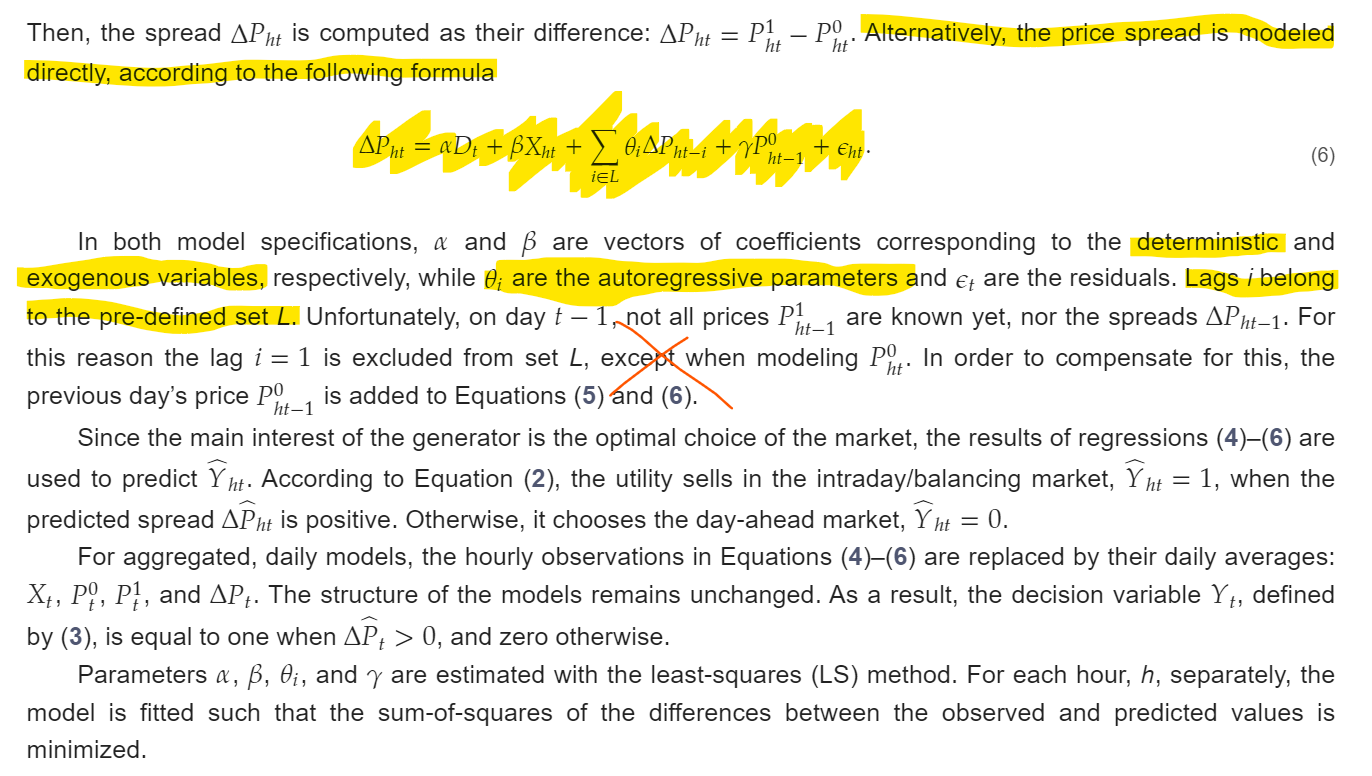
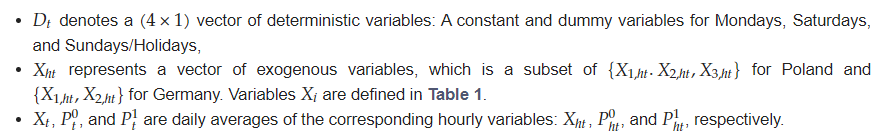

In [11]:
from src.processing import process_features,process_target

x_train_processed, x_test_processed, original_x_train_indices, original_x_test_indices = process_features(x_train, x_test, impute_nan=True)
y_train_processed, original_y_train_indices = process_target(y_train, impute_nan=True)

c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\src\processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\src\processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\src\processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\src\processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a f

### Feature engineering (categorical and lags)
* SUNLIGHT : (0 or 1), à partir des éphémérides de la journée 
* JOURNEES SPECIALES : Dummy variables for Mondays, Saturdays, Sundays, Holidays (France)
* LAGS : Lags de la variable cible $\{6,12,24,24*2,24*3,24*7,24*10,24*15,24*30\}$
* ECART OFFRE DEMANDE : conso - prod
* LAGS : Lags de conso-prod $\{6,12,24,-6,-12,-24\}$
* TEMPERATURE : Température horaire France

In [12]:
# LAGGED TARGET -----------------------------------------------------
for i in [6,12,24,24*2,24*3,24*7]:
    x_train_processed[f'target_lag_{i}'] = y_train_processed.shift(i)

In [13]:
# SUNLIGHT -----------------------------------------------------------
from datetime import datetime
from suntimes import SunTimes  
day = datetime(2024,3,13)
paris = SunTimes(2.349902, 48.852968, 35)
print(paris.riseutc(day))

x_train_processed['sunrise'] = x_train_processed.index.map(lambda x: paris.riseutc(x))
x_train_processed['sunset'] = x_train_processed.index.map(lambda x: paris.setutc(x))
x_train_processed['sunlight'] = 0
x_train_processed.loc[(x_train_processed.index>= x_train_processed.sunrise) & (x_train_processed.index<=x_train_processed.sunset),'sunlight']=1
x_train_processed.drop(['sunrise','sunset'], axis=1, inplace=True)

x_test_processed['sunrise'] = x_test_processed.index.map(lambda x: paris.riseutc(x))
x_test_processed['sunset'] = x_test_processed.index.map(lambda x: paris.setutc(x))
x_test_processed['sunlight'] = 0
x_test_processed.loc[(x_test_processed.index>= x_test_processed.sunrise) & (x_test_processed.index<=x_test_processed.sunset),'sunlight']=1
x_test_processed.drop(['sunrise','sunset'], axis=1, inplace=True)

2024-03-13 06:08:00


In [14]:
# JOURNEES SPECIALES -----------------------------------------
#Monday, Saturday, Sunday
x_train_processed['monday'] = (x_train_processed.index.dayofweek == 0).astype(int)
x_train_processed['saturday'] = (x_train_processed.index.dayofweek == 5).astype(int)
x_train_processed['sunday'] = (x_train_processed.index.dayofweek == 6).astype(int)

x_test_processed['monday'] = (x_test_processed.index.dayofweek == 0).astype(int)
x_test_processed['saturday'] = (x_test_processed.index.dayofweek == 5).astype(int)
x_test_processed['sunday'] = (x_test_processed.index.dayofweek == 6).astype(int)

In [15]:
# Jours fériés
from jours_feries_france import JoursFeries

holidays = []
for year in [2022, 2023]:
    holidays += list(JoursFeries.for_year(year).values())

x_train_processed['holiday'] = 0
for holiday in holidays:
    x_train_processed.loc[x_train_processed.index.date == holiday, 'holiday'] = 1

x_test_processed['holiday'] = 0
for holiday in holidays:
    x_test_processed.loc[x_test_processed.index.date == holiday, 'holiday'] = 1


In [16]:
# TEMPERATURE --------------------------------------------------
from sklearn.preprocessing import StandardScaler

x_train_processed['temperature'] = temp.loc[x_train_processed.index, 'Température (°C)']
x_test_processed['temperature'] = temp.loc[x_test_processed.index, 'Température (°C)']
scaler = StandardScaler()
x_train_processed['temperature'] = scaler.fit_transform(pd.DataFrame(x_train_processed['temperature']))
x_test_processed['temperature'] = scaler.transform(pd.DataFrame(x_test_processed['temperature']))

In [17]:
x_train_processed = x_train_processed.fillna(0)
x_test_processed = x_test_processed.fillna(0)

# Prepare submission

In [18]:
binarize = False
model_type = "regression"
remove_trend = True
lag_features = True

save_model = True
model_name = "XGBReg"
parameters = "lagfeatures_removetrend"

In [21]:
import pandas as pd
from src.models import build_model
from src.processing import process_features,process_target
from src.evaluation import evaluate

# Inport SVR model
from sklearn.svm import SVR

%load_ext autoreload
%autoreload 2

c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\.venv\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\.venv\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Evaluation

In [23]:
# Split data
from src.metrics import weighted_accuracy

# x_train_eval, x_test_eval, y_train_eval, y_test_eval = train_test_split(proc_x_train, y_train, test_size=0.2, random_state=42)
N_train = int(len(x_train_processed)*0.6)
x_train_eval, x_valid_eval = (x_train_processed[:N_train], x_train_processed[N_train:])
y_train_eval, y_valid_eval = y_train_processed[:N_train], y_train_processed[N_train:]
y_train_eval = process_target(y_train_eval, binarize=binarize)

# Train model
model = build_model(type=model_type)
model.fit(x_train_eval, y_train_eval)

# Evaluate model
print(evaluate(model, x_valid_eval, y_valid_eval, original_x_train_indices[N_train:]))

# Visualize predictions
import matplotlib.pyplot as plt
y_train_pred = model.predict(x_train_eval)
y_valid_pred = model.predict(x_valid_eval)

# Plot predictions
plt.plot(y_train.index, y_train, label='True')
plt.show()
plt.plot(x_train_eval.index, y_train_pred, label='Predicted')
plt.plot(x_valid_eval.index, y_valid_pred, label='valid')
plt.title('Train predictions')
plt.legend()
plt.show()


IndexError: index 6760 is out of bounds for axis 0 with size 4348

In [22]:
# LAGGED TARGET -----------------------------------------------------
for i in [6,12,24,24*2,24*3,24*7]:
    x_test_processed[f'target_lag_{i}'] = 0

In [ ]:
y_test_pred = pd.DataFrame(index=x_test.index, columns=['spot_id_delta'])
for i in original_x_test_indices:
    y_test_pred.iloc[i,'spot_id_delta'] = model.predict(x_test_processed.iloc[i,:])


## Prepare submission

In [ ]:
# Fit with full data
model = build_model(type=model_type)
model.fit(proc_x_train, proc_y_train);

In [ ]:
if save_model:
    from datetime import datetime
    y_test_pred = model.predict(proc_x_test)
    y_test_pred = pd.DataFrame(y_test_pred, index=x_test.index, columns=['spot_id_delta'])
    y_test_pred.to_csv(f'submission/{datetime.today().date()}_{model_name}_{parameters}.csv', index=True)